# Maximilian Gangloff, Trung-Dung Hoang

# 2. Q-Learning

## 2.1 Learning from experts

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv
from Q_learning import eps_policy, eps_policy_self_practice
from helpers import plot_grids_heatmap, format_val, render_grid_with_q_values
import pickle
env = TictactoeEnv()
Train=False

#### **Question 1**: Plot average reward for every 250 games during training – i.e. after the 50th game, plot the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to 100, etc. Does the agent learn to play Tic Tac Toe?

In [2]:
train_q1 = False
if Train or train_q1:
    eps_agents = np.arange(0,1,0.1)
    rewards = []
    for eps_agent in eps_agents:
        print('Started learning with eps_agent={:.1f}'.format(eps_agent))
        _, rewards_250 = eps_policy(env, Q_table=dict(), eps_agent=eps_agent)
        rewards.append(rewards_250)

    with open("./rewards/q1", "wb") as fp:
        pickle.dump((eps_agents, rewards), fp)
else:
    with open("./rewards/q1", "rb") as fp:
        eps_agents, rewards = pickle.load(fp)


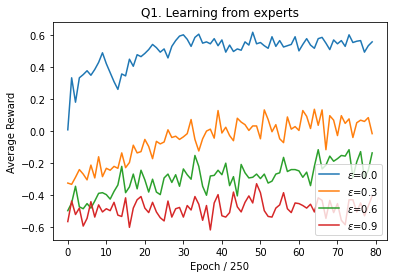

In [3]:
indices = [0, 3, 6, 9] #Corresponds to 0.0, 0.3, 0.6 and 0.9
for ind in indices:
    plt.plot(rewards[ind], label=r'$\epsilon$=' + '{:.1f}'.format(eps_agents[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q1. Learning from experts')
plt.legend(loc='lower right')
plt.savefig('./plots/q1.png')
plt.show()


### 2.1.1 Decreasing exploration

#### **Question 2**: Plot average reward for every 250 games during training. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of n* ?


In [4]:
train_q2 = False
if Train or train_q2:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    expl_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with n*={}'.format(nb_expl_games))
        _, rewards_expl_250 = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games)
        expl_rewards.append(rewards_expl_250)

    with open("./rewards/q2", "wb") as fp:
        pickle.dump((expl_rewards, expl_games), fp)
else:
    with open("./rewards/q2", "rb") as fp:
        expl_rewards, expl_games = pickle.load(fp)


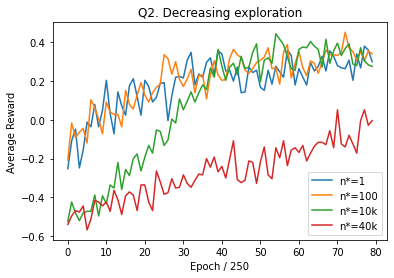

In [5]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(expl_rewards[ind], label='n*=' + format_val(expl_games[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q2. Decreasing exploration')
# plt.title('Average rewards after every 250 games with different values of n*')
plt.legend()
plt.savefig('./plots/q2.png')
plt.show()

#### **Question 3**: After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents – when measuring the ‘test’ performance, put $\epsilon$ = 0 and do not update the Q-values. Plot Mopt and Mrand over time. Describe the differences and the similarities between these curves and the ones of the previous question.


In [6]:
train_q3 = False
if Train or train_q3:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with n*={}'.format(nb_expl_games))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games, eval_every=250)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q3", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q3", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)



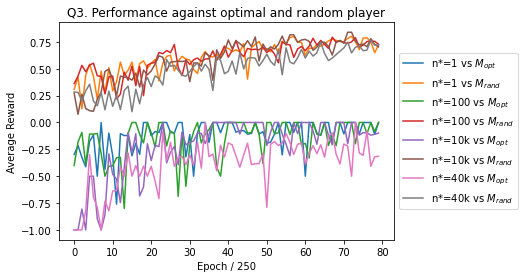

In [7]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{rand}$")
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q3. Performance against optimal and random player')
plt.savefig('./plots/q3.png', bbox_inches='tight')
plt.show()

### 2.1.2 Good expoerts and bad experts

In [8]:
best_expl_games = 10000

#### **Question 4**: After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents – for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?


In [9]:
train_q4 = False
if Train or train_q4:
    eps_opts = np.arange(0,1,0.1)
    eps_rewards = []
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_opt in eps_opts:
        print('Started learning with eps_opt={:.1f}'.format(eps_opt))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_opt=eps_opt, decay_eps=True, expl_games=best_expl_games, eval_every=250)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q4", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts), fp)
else:
    with open("./rewards/q4", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts = pickle.load(fp)

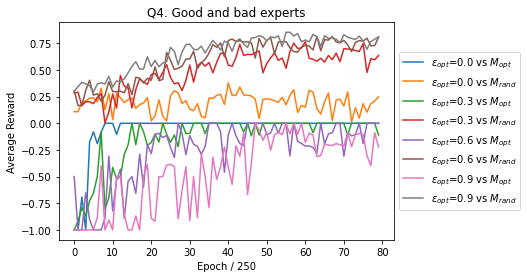

In [10]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label=r"$\epsilon_{opt}$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label=r"$\epsilon_{opt}$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q4. Good and bad experts')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q4.png', bbox_inches='tight')
plt.show()

#### **Question 5**: What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?

In [11]:
print('Best M_opt after 20000 games: {:.3f}'.format(np.max(eps_vs_opt_rewards)))
print('Best M_rnd after 20000 games: {:.3f}'.format(np.max(eps_vs_rnd_rewards)))

Best M_opt after 20000 games: 0.000
Best M_rnd after 20000 games: 0.868


The highest $\begin{aligned}M_{opt}\end{aligned}$ is equal to 0. This is normal and to be awaited since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in a draw.

The highest $\begin{aligned}M_{rand}\end{aligned}$ is equal to 0.882. This value is pretty high but is not out of the ordinary since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in either a win for the agent or a draw.



#### **Question 6**: Assume that Agent 1 learns by playing against Opt(0) and find the optimal Q-values Q1(s, a). In addition, assume that Agent 2 learns by playing against Opt(1) and find the optimal Q-values Q2(s, a). Do Q1(s, a) and Q2(s, a) have the same values?

The answer is no. Since Agent 1 plays against an optimal player who always chooses the best action, the game always ends in either a draw or a loose for Agent 1. This means that all the Q-values of Agent 1 will be smaller or equal 0 since the only possibility to obtain a positive reward is by winning a game. On the other hand, Agent 2 will win most of its games and never loose once he has learned the optimal Q-values. Thus he will have Q-values that are greater then 0.

### Learning by self-practive

#### **Question 7**:  After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different values of $\epsilon$ ∈ [0, 1). Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?

In [12]:
train_q7 = False
if Train or train_q7:
    eps_agents = np.arange(0, 1, 0.1)
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_agent in eps_agents:
        print('Started learning with eps_agent={:.1f}'.format(eps_agent))
        _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), eps_agents=eps_agent)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q7", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents), fp)
else:
    with open("./rewards/q7", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents = pickle.load(fp)

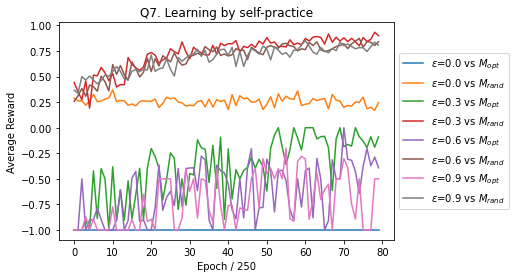

In [13]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label=r"$\epsilon$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label=r"$\epsilon$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q7. Learning by self-practice')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q7.png', bbox_inches='tight')
plt.show()

#### **Question 8**: After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of n*?


In [14]:
train_q8 = False
if Train or train_q8:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for expl_game in expl_games:
        print('Started learning with expl_game={:.1f}'.format(expl_game))
        Q_table, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), decay_eps=True, expl_games=expl_game)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q8", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q8", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)

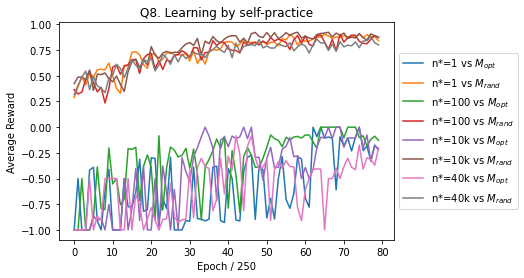

In [15]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q8. Learning by self-practice')
plt.savefig('./plots/q8.png', bbox_inches='tight')
plt.show()

#### Question 9: What are the highest values for Mopt and Mrand achieved after 20 000 games?

In [16]:
best_M_opt = max(max(eps_vs_opt_rewards))
best_M_rand = max(max(eps_vs_rnd_rewards))
print('Best M_opt: {}'.format(best_M_opt))
print('Best M_rand: {:.4f}'.format(best_M_rand))

Best M_opt: 0.0
Best M_rand: 0.9240


#### Question 10: 

In [17]:
best_expl_games = 10000
train_q10 = False
if Train or train_q10:
    print('Started learning with expl_game={}'.format(best_expl_games))
    Q_table, _, _ = eps_policy_self_practice(env, Q_table=dict(), nb_epochs=20000, decay_eps=True, expl_games=best_expl_games, eval_every=-1)
    #Q_table, _ = eps_policy(env, Q_table=dict(), nb_epochs=20000, decay_eps=True, expl_games=best_expl_games, eval_every=-1)

    with open("./rewards/q10", "wb") as fp:
        pickle.dump((Q_table), fp)
else:
    with open("./rewards/q10", "rb") as fp:
        Q_table = pickle.load(fp)

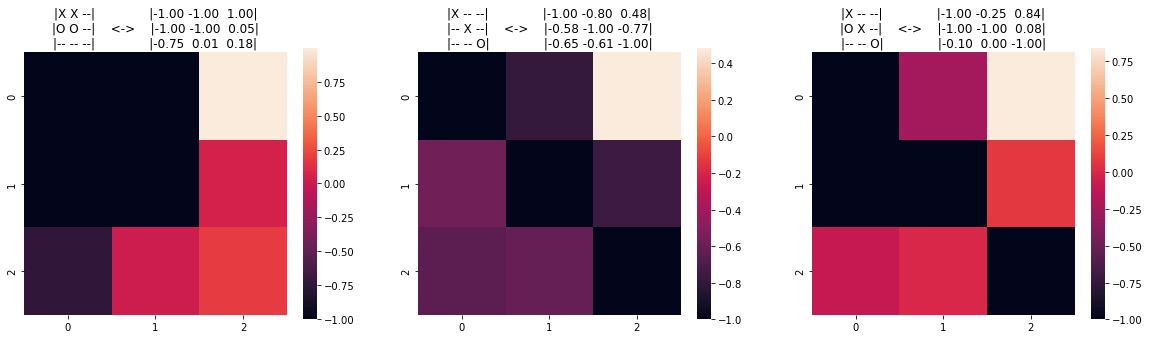

In [18]:

grid0 = np.array([[1,1,0],
                [-1,-1,0],
                [0,0,0]])

grid1 = np.array([[1,0,0],
                [0,1,0],
                [0,0,-1]])

grid2 = np.array([[1,0,0],
                [-1,1,0],
                [0,0,-1]])

plot_grids_heatmap(Q_table, [grid0, grid1, grid2])
plt.savefig('./plots/q10',  bbox_inches='tight')

# 3. Deep Q-Learning

In [19]:
from deep_Q_learning import train, self_train, grid_to_state_tensor
import seaborn as sns
import numpy as np
import torch
import os

In [20]:
TRAIN = False
COLORS = ['tab:'+i for i in ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']]

## 3.2 Learning from experts

#### Question 11. Plot average reward and average training loss for every 250 games during training. Does the loss decrease? Does the agent learn to play Tic Tac Toe?

In [21]:
if TRAIN or not os.path.isfile('rewards/q11.pkl'):
    eps_agent_to_results = {}
    for eps_agent in range(10):
        eps_agent = eps_agent/10
        _, losses, rewards, Mrands, Mopts = train(eps_agent=eps_agent, nb_epochs=20000,seed=123)
        eps_agent_to_results[eps_agent] = (losses, rewards, Mrands, Mopts)
    with open('rewards/q11.pkl','wb') as f:
        pickle.dump(eps_agent_to_results, f)
else:
    eps_agent_to_results = pickle.load(open('rewards/q11.pkl','rb'))

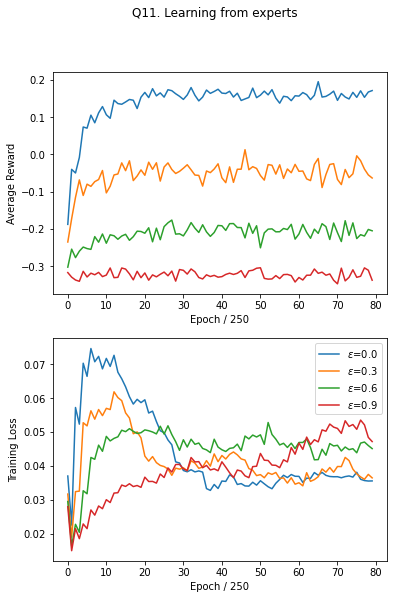

In [22]:
fig, axs = plt.subplots(2, figsize=(6,9))
for eps in [0,0.3,0.6,0.9]:
    axs[0].plot(eps_agent_to_results[eps][1], label=r"$\epsilon$=" + '{:.1f}'.format(eps))
    axs[1].plot(eps_agent_to_results[eps][0], label=r"$\epsilon$=" + '{:.1f}'.format(eps))
    
axs[0].set_xlabel('Epoch / 250')
axs[1].set_xlabel('Epoch / 250')
axs[0].set_ylabel('Average Reward')
axs[1].set_ylabel('Training Loss')

plt.suptitle('Q11. Learning from experts')

plt.legend()
plt.savefig('plots/q11.png')

plt.show()

#### Question 12. Repeat the training but without the replay buffer and with a batch size of 1: At every step, update the network by using only the latest transition. What do you observe?


In [23]:
if TRAIN or not os.path.isfile('rewards/q12.pkl'):
    _, losses, rewards, Mrands, Mopts = train(eps_agent=0.0, buffer_size=1, batch_size=1, nb_epochs=20000,seed=123)
    with open('rewards/q12.pkl','wb') as f:
        pickle.dump((losses, rewards,Mrands,Mopts), f)
else:
    losses, rewards, Mrands, Mopt = pickle.load(open('rewards/q12.pkl','rb'))

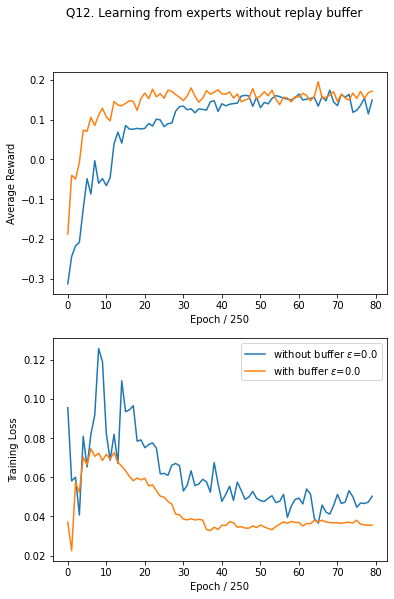

In [24]:
fig, axs = plt.subplots(2,figsize=(6,9))
axs[0].plot(rewards, label="without buffer "+r"$\epsilon$=0.0")
axs[0].plot(eps_agent_to_results[0.0][1], label="with buffer "+r"$\epsilon$=0.0")
axs[0].set_xlabel('Epoch / 250')
axs[0].set_ylabel('Average Reward')

axs[1].plot(losses, label="without buffer "+r"$\epsilon$=0.0")
axs[1].plot(eps_agent_to_results[0.0][0], label="with buffer "+r"$\epsilon$=0.0")
axs[1].set_xlabel('Epoch / 250')
axs[1].set_ylabel('Training Loss')

plt.suptitle('Q12. Learning from experts without replay buffer')

plt.legend()
plt.savefig('plots/q12.png')

plt.show()

Instead of fixing $\epsilon$, use $\epsilon(n)$ in Equation 1. For different values of $n^*$, run your DQN against Opt(0.5) for 20000 games – switch the 1st player after every game. Choose several values of $n^*$ from a reasonably wide interval between 1 to 40000 – particularly, include $n^*$ = 1.

#### Question 13. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents. Plot $M_{opt}$ and $M_{rand}$ over time. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^*$?


In [25]:
if TRAIN or not os.path.isfile('rewards/q13.pkl'):
    n_star_to_results={}
    for max_epoch in [1, 10, 100, 1000, 5000, 10000, 20000, 40000]:
        _, rewards, losses, Mrands, Mopts = train(decay_eps=True, max_epoch= max_epoch, nb_epochs=20000,seed=123)
        n_star_to_results[max_epoch] = (rewards, losses, Mrands, Mopts)

    with open('rewards/q13.pkl','wb') as f:
        pickle.dump(n_star_to_results, f)
else:
    n_star_to_results = pickle.load(open('rewards/q13.pkl','rb'))

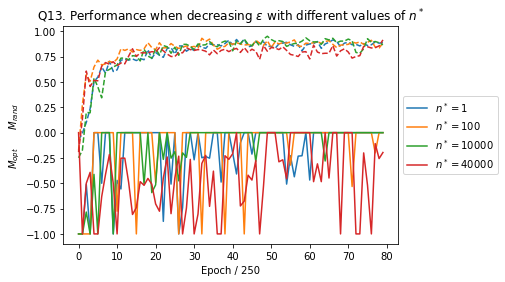

In [26]:
for i, n in enumerate([1,100,10000,40000]):
    plt.plot( n_star_to_results[n][2], linestyle='dashed', color=COLORS[i])
    plt.plot( n_star_to_results[n][3], color=COLORS[i], label=r'$n^* = $'+str(n))

plt.ylabel(r'$M_{opt}$      $M_{rand}$')
plt.xlabel('Epoch / 250')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q13. Performance when decreasing $\epsilon$ with different values of $n^*$')
plt.savefig('plots/q13.png', bbox_inches='tight')
plt.show()

Choose the best value of $n^*$ that you found. Run DQN against Opt($\epsilon_{opt}$) for different values of $\epsilon_{opt}$ for 20000 games – switch the 1st player after every game. Choose several values of $\epsilon_{opt}$ from a reasonably wide interval between 0 to 1 – particularly, include $\epsilon_{opt}$ = 0.

#### Question 14. After every 250 games during training, compute the ‘test’  $M_{opt}$ and $M_{rand}$ for your agents – for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?



In [27]:
best_max_epoch=10000

In [28]:
if TRAIN or not os.path.isfile('rewards/q14.pkl'):
    eps_opt_to_results={}
    for eps_opt in range(10):
        eps_opt = eps_opt/10
        _, rewards, losses, Mrands, Mopts = train(eps_opt=eps_opt, decay_eps=True, max_epoch= best_max_epoch, nb_epochs=20000,seed=123)
        eps_opt_to_results[eps_opt] = (rewards, losses, Mrands, Mopts)

    with open('rewards/q14.pkl','wb') as f:
        pickle.dump(eps_opt_to_results, f)
else:
    eps_opt_to_results = pickle.load(open('rewards/q14.pkl','rb'))
    

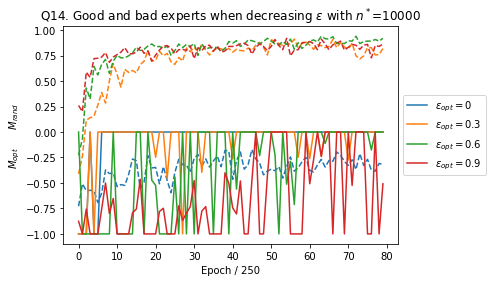

In [29]:
for i, eps in enumerate([0, 0.3,0.6,0.9]):
    plt.plot( eps_opt_to_results[eps][2], linestyle='dashed', color=COLORS[i])
    plt.plot( eps_opt_to_results[eps][3], color=COLORS[i], label=r'$\epsilon_{opt} = $'+str(eps))
    
plt.ylabel(r'$M_{opt}$      $M_{rand}$')
plt.xlabel('Epoch / 250')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q14. Good and bad experts when decreasing $\epsilon$ with $n^*$={}'.format(best_max_epoch))
plt.savefig('plots/q14.png', bbox_inches='tight')
plt.show()


#### Question 15. What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20000 games?

In [30]:
print("Different eps_agent")
eps_rand, best_M_rand = max(((k,max(v[2])) for k,v in eps_agent_to_results.items()), key=lambda x: x[1]) # Mrand
eps_opt, best_M_opt = max(((k,max(v[3])) for k,v in eps_agent_to_results.items()), key=lambda x: x[1]) # Mopt
print(r'Best M_opt {} at eps_agent={}'.format(best_M_opt, eps_opt))
print(r'Best M_rand {} at eps_agent={}'.format(best_M_rand, eps_rand))


Different eps_agent
Best M_opt 0.0 at eps_agent=0.0
Best M_rand 0.928 at eps_agent=0.1


In [31]:
print("Different eps_opt")
eps_rand, best_M_rand = max(((k,max(v[2])) for k,v in eps_opt_to_results.items()), key=lambda x: x[1]) # Mrand
eps_opt, best_M_opt = max(((k,max(v[3])) for k,v in eps_opt_to_results.items()), key=lambda x: x[1]) # Mopt
print(r'Best M_opt {} at eps_agent={}'.format(best_M_opt, eps_opt))
print(r'Best M_rand {} at eps_agent={}'.format(best_M_rand, eps_rand))



Different eps_opt
Best M_opt 0.0 at eps_agent=0.0
Best M_rand 0.952 at eps_agent=0.5


In [32]:
print("Decreasing eps")
n_rand, best_M_rand = max(((k,max(v[2])) for k,v in n_star_to_results.items()), key=lambda x: x[1]) # Mrand
n_opt, best_M_opt = max(((k,max(v[3])) for k,v in n_star_to_results.items()), key=lambda x: x[1]) # Mopt
print(r'Best M_opt {} at n={}'.format(best_M_opt, n_opt))
print(r'Best M_rand {} at n={}'.format(best_M_rand, n_rand))


Decreasing eps
Best M_opt 0.0 at n=1
Best M_rand 0.952 at n=10000


## 3.3  Learning by self-practice

#### Question 16. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different values of $\epsilon \in [0, 1)$. Plot $M_{opt}$ and $M_{rand}$ over time. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?

In [33]:
if TRAIN or not os.path.isfile('rewards/q16.pkl'):
    self_eps_agent_to_results={}
    for eps_agent in range(10):
        eps_agent = eps_agent/10
        _, rewards, losses, Mrands, Mopts = self_train(eps_agent=eps_agent, decay_eps=False, nb_epochs=20000,seed=123)
        self_eps_agent_to_results[eps_agent] = (rewards, losses, Mrands, Mopts)

    with open('rewards/q16.pkl','wb') as f:
        pickle.dump(self_eps_agent_to_results, f)
else:
    self_eps_agent_to_results = pickle.load(open('rewards/q16.pkl','rb'))

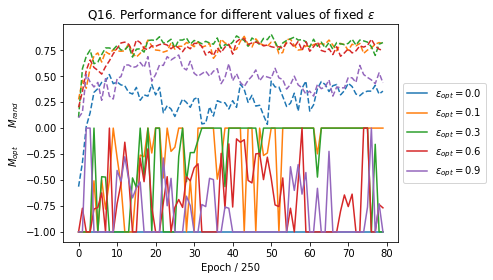

In [34]:
for i, eps in enumerate([0.0, 0.1, 0.3, 0.6,0.9]):
    plt.plot( self_eps_agent_to_results[eps][2], linestyle='dashed', color=COLORS[i])
    plt.plot( self_eps_agent_to_results[eps][3], color=COLORS[i], label=r'$\epsilon_{opt} = $'+str(eps))
    
plt.ylabel(r'$M_{opt}$      $M_{rand}$')
plt.xlabel('Epoch / 250')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q16. Performance for different values of fixed $\epsilon$')
plt.savefig('plots/q16.png', bbox_inches='tight')
plt.show()


Instead of fixing $\epsilon$, use $\epsilon(n)$ in Equation 1 with different values of $n^*$.

#### Question 17: After every 250 games during training, compute the 'test' $M_{opt}$ and $M_{rand}$ for your agents. Plot $M_{opt}$ and $M_{rand}$ over time. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^*$?

In [35]:
if TRAIN or not os.path.isfile('rewards/q17.pkl'):
    self_n_star_to_results={}
    for n_star in [1, 10, 100, 1000, 5000, 10000, 20000, 40000]:
        _, rewards, losses, Mrands, Mopts = self_train(decay_eps=True, max_epoch= n_star, nb_epochs=20000,seed=123)
        self_n_star_to_results[n_star] = (rewards, losses, Mrands, Mopts)

    with open('rewards/q17.pkl','wb') as f:
        pickle.dump(self_n_star_to_results, f)
else:
    self_n_star_to_results = pickle.load(open('rewards/q17.pkl','rb'))
    

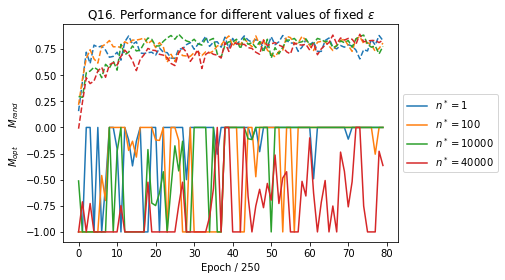

In [36]:

for i, n in enumerate([1,100,10000, 40000]):
    plt.plot( self_n_star_to_results[n][2], linestyle='dashed', color=COLORS[i])
    plt.plot( self_n_star_to_results[n][3], color=COLORS[i], label=r'$n^* = $'+str(n))

plt.ylabel(r'$M_{opt}$      $M_{rand}$')
plt.xlabel('Epoch / 250')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q16. Performance for different values of fixed $\epsilon$')
plt.savefig('plots/q17.png', bbox_inches='tight')
plt.show()


#### Question 18: What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20000 games?

In [37]:
print("Different eps")
eps_rand, best_M_rand = max(((k,max(v[2])) for k,v in self_eps_agent_to_results.items()), key=lambda x: x[1]) # Mrand
eps_opt, best_M_opt = max(((k,max(v[3])) for k,v in self_eps_agent_to_results.items()), key=lambda x: x[1]) # Mopt
print(r'Best M_opt {} at n={}'.format(best_M_opt, eps_opt))
print(r'Best M_rand {} at n={}'.format(best_M_rand, eps_rand))


Different eps
Best M_opt 0.0 at n=0.1
Best M_rand 0.904 at n=0.3


In [38]:
print("Decreasing eps")
n_rand, best_M_rand = max(((k,max(v[2])) for k,v in self_n_star_to_results.items()), key=lambda x: x[1]) # Mrand
n_opt, best_M_opt = max(((k,max(v[3])) for k,v in self_n_star_to_results.items()), key=lambda x: x[1]) # Mopt
print(r'Best M_opt {} at n={}'.format(best_M_opt, n_opt))
print(r'Best M_rand {} at n={}'.format(best_M_rand, n_rand))


Decreasing eps
Best M_opt 0.0 at n=1
Best M_rand 0.904 at n=1000


#### Question 19 For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?

In [39]:
def estimate(policy_net, grid):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    nX = len(np.where(grid==1))
    nO = len(np.where(grid==-1))
    assert nX >= nO, "invalid state"
    
    if nX == nO:
        player = 'X'
    else:
        player = 'O'
        
    state = grid_to_state_tensor(grid, player, device)
    return policy_net(state).reshape(3,3).detach().cpu().numpy()


def plot_grids_heatmap(policy_net, grids, path='./q19'):  
    """
    Plots and saves 
    """
    fig = plt.figure(figsize=(20, 5))
    axes = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]

    for idx, grid in enumerate(grids):
        state = tuple(grid.flatten())
        if sum(state) < 0:
            raise ValueError('An invalid grid has been chosen. Player X -> 1 always starts.')
        if sum(state) > 1:
            raise ValueError('An invalid grid has been chosen. The two players X -> 1 and O -> -1 always play one after the other.')
        q_values = np.ones(grid.shape)*-1
        try:
            q_values = estimate(policy_net,grid)
            sns.heatmap(q_values, ax=axes[idx], square=True)
            axes[idx].set_title(render_grid_with_q_values(grid, q_values), loc='center')
        except:
            raise ValueError('The game has already been finished or the current state has not been encountered.')

    plt.savefig(path,  bbox_inches='tight')

In [40]:
if TRAIN or not os.path.isfile('rewards/q19.pt'):
    policy_net,_,_,_,_ = self_train(decay_eps=True, max_epoch=100000, nb_epochs=20000, eval_every=-1)

    torch.save(policy_net,'rewards/q19.pt')
else:
    policy_net = torch.load('rewards/q19.pt')
    


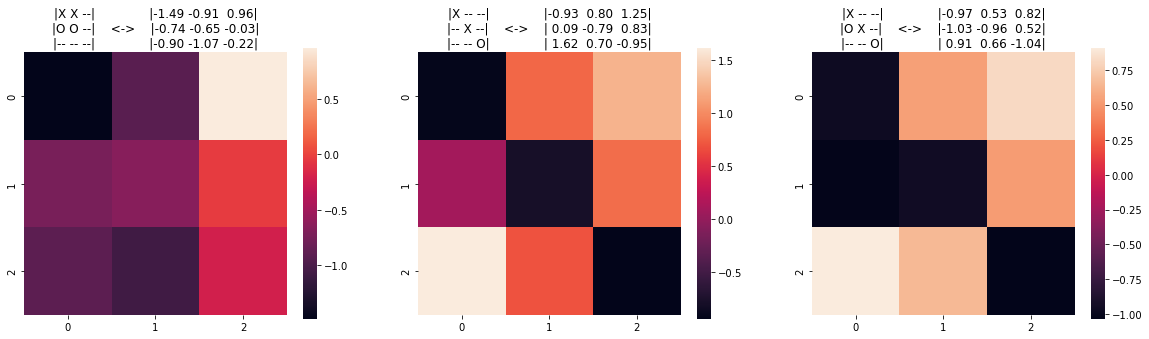

In [41]:
grid0 = np.array([[1,1,0],
                [-1,-1,0],
                [0,0,0]])

grid1 = np.array([[1,0,0],
                [0,1,0],
                [0,0,-1]])

grid2 = np.array([[1,0,0],
                [-1,1,0],
                [0,0,-1]])

plot_grids_heatmap(policy_net, [grid0, grid1, grid2],'plots/q19.png')


# 4. Comparing Q-Learning with Deep Q-Learning

We define the training time $T_{train}$ as the number of games an algorithm needs to play in order to reach 80% of its final performance according to both $M_{opt}$ and $M_{rand}$.

#### Question 20. Include a table showing the best performance (the highest $M_{opt}$ and $M_{rand}$) of Q-Learning and DQN (both for learning from experts and for learning by self-practice) and their corresponding training time.

In [51]:
print("Learn from experts DQN")
n_star_to_combined_results = {}
for n, (_,_,Mrands, Mopts) in n_star_to_results.items():
    n_star_to_combined_results[n] = (np.array(Mrands) + np.array(Mopts)).tolist()
    
n, best_M = max(((k,max(v)) for k,v in n_star_to_combined_results.items()), key=lambda x: x[1]) 
print(n,best_M)
for i, combined_M in enumerate(n_star_to_combined_results[n]):
    if combined_M >= 0.8*best_M:
        print("Reachs 80% best performance at step {}".format(i*250+250))
        break

Learn from experts DQN
10000 0.952
Reachs 80% best performance at step 5500


In [52]:
print("Self-practice DQN")
self_n_star_to_combined_results = {}
for n, (_,_,Mrands, Mopts) in self_n_star_to_results.items():
    self_n_star_to_combined_results[n] = (np.array(Mrands) + np.array(Mopts)).tolist()
    
n, best_M = max(((k,max(v)) for k,v in self_n_star_to_combined_results.items()), key=lambda x: x[1])
print(n,best_M)
for i, combined_M in enumerate(self_n_star_to_combined_results[n]):
    if combined_M >= 0.8*best_M:
        print("Reachs 80% best performance at step {}".format(i*250+250))
        break

Self-practice DQN
1000 0.904
Reachs 80% best performance at step 1500


#### Question 21. Compare your results for DQN and Q-Learning.